## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:486: UserWarning: matplotlibrc text.usetex option can not be used unless TeX-3.1415 or later is installed on your system
  'installed on your system') % tex_req)
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:493: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.5 or later is installed on your system
  warnings.warn('matplotlibrc text.usetex can not be used with *Agg '
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:508: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-7.07 or later is installed on your system
  'installed on your system') % gs_req)


In [2]:
import spark_fof

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

## Set up data

In [4]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

In [5]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 1000000
ngs = 5
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
centers = np.random.rand(ngs,3)*1.8 - 0.9
for group, center in zip(range(ngs), centers): 
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.005,0,0],[0,.005,0],[0,0,.005]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

## Start Spark

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
from pyspark import SparkContext, SparkConf

In [8]:
conf = SparkConf()

In [9]:
import os

In [10]:
os.environ['SPARK_DRIVER_MEMORY']= '4G'

In [11]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '5G')
conf.set('spark.driver.memory', '4G')


In [12]:
sc = SparkContext(master='local[4]', conf=conf, batchSize=0)

In [13]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [14]:
N = 4
tau = 0.05
mins = [-1,-1,-1]
maxes= [1,1,1]
domain_containers = spark_fof.setup_domain(N,tau,maxes,mins)

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


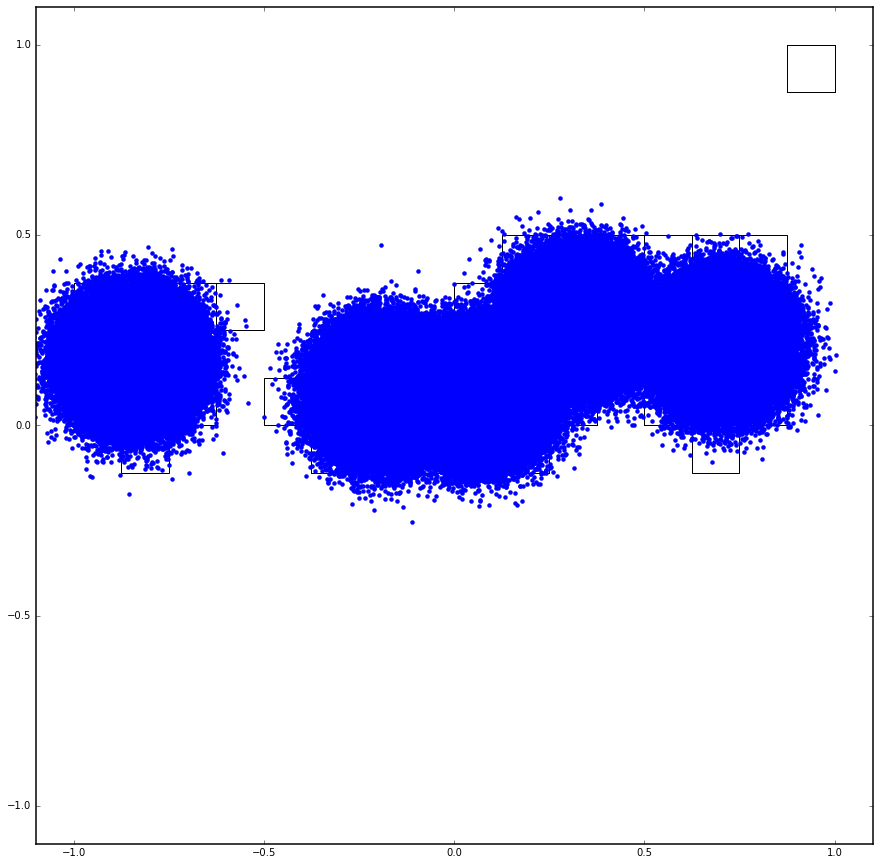

In [15]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles[::1000]: 
    x,y,z = p['pos']
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(x, y, z,2**N, -1,-1,-1, 1,1,1)], ax=ax)
#    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
# for r in domain_containers: 
#     plot_rectangle(r.parent, ax=ax)
ax.plot(particles['pos'][:,0], particles['pos'][:,1], '.')

### Make the base RDD

In [16]:
p_rdd = sc.parallelize(particles)

### Partition particles into domains and set the partition part of local group ID

In [18]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values())

In [ ]:
part_rdd.count()

In [ ]:
sc.show_profiles()

### Run the local FOF

In [19]:
from spark_util import spark_cython

In [20]:
run_fof = spark_cython('fof', 'run')

In [21]:
def run_local_fof(index, particle_iter, tau): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        run_fof(part_arr, tau)
    part_arr['iOrder'] = index
    return part_arr

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        gid = part_arr[i]['iGroup']
        part_arr[i]['iGroup'] = spark_fof.encode_gid(partition_index, gid, 16)
    return part_arr

In [49]:
part_rdd.mapPartitionsWithIndex(run_local_fof).collect()

[([-0.2017277479171753, -0.5116086006164551, 0.25168800354003906], 0, 2357),
 ([-0.32397979497909546, -0.5175694823265076, 0.22052833437919617], 0, 2357),
 ([-0.2017277479171753, -0.5116086006164551, 0.25168800354003906], 0, 2358),
 ([-0.3118076026439667, -0.5760855078697205, 0.4098624885082245], 0, 2597),
 ([-0.1536763310432434, -0.5940067172050476, 0.3876684606075287], 0, 2598),
 ([-0.2433624565601349, -0.4748691916465759, 0.40354129672050476], 0, 2613),
 ([-0.2017277479171753, -0.5116086006164551, 0.25168800354003906], 0, 2613),
 ([-0.24403367936611176, -0.48283424973487854, 0.30490750074386597], 0, 2613),
 ([-0.315173476934433, -0.4985677897930145, 0.41830959916114807], 0, 2613),
 ([-0.3118076026439667, -0.5760855078697205, 0.4098624885082245], 0, 2613),
 ([-0.26225635409355164, -0.5550345182418823, 0.3926166892051697], 0, 2613),
 ([-0.2911744713783264, -0.5060533285140991, 0.34295889735221863], 0, 2613),
 ([-0.2433624565601349, -0.4748691916465759, 0.40354129672050476], 1, 2614),


In [50]:
sc.show_profiles()

Profile of RDD<id=9>
         67624 function calls in 0.595 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4096    0.129    0.000    0.158    0.000 serializers.py:259(dump_stream)
     4096    0.088    0.000    0.316    0.000 <ipython-input-21-571b8f0bcf9c>:1(run_local_fof)
     4096    0.051    0.000    0.594    0.000 worker.py:104(process)
     4096    0.051    0.000    0.191    0.000 {numpy.core.multiarray.fromiter}
     4096    0.041    0.000    0.068    0.000 serializers.py:217(load_stream)
     4293    0.037    0.000    0.140    0.000 serializers.py:136(load_stream)
     4293    0.034    0.000    0.103    0.000 serializers.py:155(_read_with_length)
     4293    0.034    0.000    0.059    0.000 serializers.py:542(read_int)
      197    0.021    0.000    0.021    0.000 {cPickle.dumps}
     4490    0.021    0.000    0.021    0.000 {method 'read' of 'file' objects}
     4096    0.016    0.000    0.0

In [ ]:
fof_rdd = part_rdd.mapPartitions(run_local_fof).mapPartitionsWithIndex(set_group_id)

In [ ]:
fof_rdd.take(10)

### Group Merging stage

In [ ]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [ ]:
merged_rdd = fof_analyzer.merge_groups(0)

In [ ]:
merged_rdd.collect()

In [ ]:
sc.show_profiles()

In [ ]:
p_arr = np.array(fof_analyzer.particle_rdd.collect())

In [ ]:
groups = np.unique(p_arr['gid'])

In [ ]:
for g in groups:
    inds = np.where(p_arr['gid'] == g)
    if g in m.keys():
        p_arr['gid'][inds] = m[g]

In [ ]:
p_arr

In [ ]:
def remap_gid_partition(particles, gid_map):
    p_arr = np.fromiter(particles, spark_fof.pdt)
    groups = np.unique(p_arr['gid'])
    for g in groups:
        inds = np.where(p_arr['gid'] == g)
        if g in gid_map.keys():
            p_arr['gid'][inds] = gid_map[g]
    return p_arr

In [ ]:
ps = fof_analyzer.particle_rdd.collect()

In [ ]:
fof_analyzer.particle_rdd.collect()

## try get_bin with cython

In [ ]:
import numpy as np
# import pyximport
# pyximport.install(setup_args={"include_dirs":np.get_include()},
#                   reload_support=True)

In [ ]:
xs = np.random.rand(1000000)
ys = np.random.rand(1000000)

### Setup cython on workers

looks like some helpful info here: https://www.4info.com/Blog/October-2014/Enhancing-Spark-with-IPython-Notebook-and-Cython

In [ ]:
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_util.py')

In [ ]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()})   

In [ ]:
from spark_util import spark_cython

In [ ]:
def get_particle_bin(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p.x,p.y,100,-1,-1,1,1)

def get_particle_bin_numpy(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p['x'],p['y'],100,-1,-1,1,1)

def get_particle_bin_partition(particles, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    bins = np.zeros(n, dtype=np.int32)
    
    for i, p in enumerate(particles): 
        xs[i]=p.x
        xs[i]=p.y
    
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(xs,ys,bins)
    
    for bin in bins: yield bin

def get_particle_bin_partition_numpy(particles): 
    p_arr = np.fromiter(particles, pdt)
    bins = np.zeros(len(p_arr), dtype=np.int)
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(p_arr['x'], p_arr['y'], bins)
    return bins

def get_particle_bin_python(p):
    return get_bin(p['x'],p['y'],100,[-1,-1],[1,1])

In [ ]:
pdt = np.dtype([('x','f8'), ('y','f8')])

p_np_arr = np.zeros(10000000,dtype=pdt)

for i in range(len(p_np_arr)):
    p_np_arr[i] = np.random.rand(2)

In [ ]:
#p_arr_rdd = sc.parallelize(p_arr).cache()
p_np_arr_rdd = sc.parallelize(p_np_arr).cache()

In [ ]:
p_np_arr_rdd.count()

In [ ]:
%time p_np_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

In [ ]:
sc.show_profiles()

In [ ]:
import cPickle as pickle
class PickleSerializer2(pyspark.serializers.FramedSerializer):

    """
    Serializes objects using Python's pickle serializer:

        http://docs.python.org/2/library/pickle.html

    This serializer supports nearly any Python object, but may
    not be as fast as more specialized serializers.
    """

    def dumps(self, obj):
        return pickle.dumps(obj, protocol)

    if sys.version >= '3':
        def loads(self, obj, encoding="bytes"):
            return pickle.loads(obj, encoding=encoding)
    else:
        def loads(self, obj, encoding=None):
            print 'object size', len(obj)
            return pickle.loads(obj)


In [ ]:
class NumpySerializer(pyspark.serializers.FramedSerializer):
    import numpy as np
    
    def __init__(self, dtype): 
        self.dtype = dtype
        super(NumpySerializer, self).__init__()
    
    def dumps(self, obj):
        print 'SERIALIZING'
        return obj.tobytes()
    def loads(self, obj):
        print 'string length: ', len(obj)
        return np.fromstring(obj, dtype=self.dtype)
    
    def _read_with_length(self, stream):
        length = pyspark.serializers.read_int(stream)
        print 'stream length: ', length
        if length == pyspark.serializers.SpecialLengths.END_OF_DATA_SECTION:
            raise EOFError
        elif length == pyspark.serializers.SpecialLengths.NULL:
            return None
        obj = stream.read(length)
        if len(obj) < length:
            raise EOFError
        return self.loads(obj)
    

In [ ]:
ns = NumpySerializer(pdt)

In [ ]:
new_arr_rdd = p_np_arr_rdd._reserialize(pyspark.serializers.BatchedSerializer(NumpySerializer(pdt), 1024))

In [ ]:
new_arr_rdd._jrdd_deserializer

In [ ]:
p_np_arr_rdd._jrdd_deserializer = NumpySerializer(pdt)

In [ ]:
p_np_arr_rdd.count()

In [ ]:
%timeit pickle.dumps(p_np_arr)

In [ ]:
%timeit p_np_arr.tostring()

In [ ]:
%time new_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

In [ ]:
ps = new_arr_rdd.count()

In [ ]:
sc.show_profiles()

In [ ]:
bin(1 << 32)

In [ ]:
bin(1) 

In [ ]:
bin(101)

In [ ]:
2**32

In [ ]:
x = np.binary_repr(1, width=32)

In [ ]:
y = np.binary_repr(1, width=32)

In [ ]:
int(x+y,2)

In [ ]:
np.binary_repr(int(x+y,2), width=64)

In [ ]:
# encode a 32-bit partition ID (pid) and 32-bit cluster ID (cid) into one 64-bit integer
encode_gid = lambda pid, cid: np.int64(int(np.binary_repr(pid,width=32)+np.binary_repr(cid,width=32),2))